In this notebook we try to explore possible network architectures for our Image-to-Image translation problem. In this regard, we will begin with a simplified problem where we only use one filter (*gotham* filter).

## Architecture

The architecture of the network is inspired by the one proposed by [Izuka and Simo-Serra](http://hi.cs.waseda.ac.jp/%7Eiizuka/projects/colorization/data/colorization_sig2016.pdf) and illustrated below

![](https://cloud.githubusercontent.com/assets/22426131/20623098/5031fff4-b31b-11e6-8594-a54e83fce131.PNG)

Our network will have two branches:

1. **Feature Extractor**: This branch will be in charge of extracting relevant features of the input picture. To this end, we use the Inception-Resnet-V2 pre-trained model. In particular we use the last layer before applying Softmax. 
2. **Encoder-Decoder**: This branch works similar to an autoencoder. Furthermore, it contains a *Merge Layer* which merges the extracted features from branch 1.


In this notebook, we initially only consider just the 2. Our main goal here, is to see if the network is able to overfit a small dataset.

# Load Images

The loading of the images is temporal, in the future we will be using TFRecord files! However, for this little test, this method is enough. For this test, I have created two folders inside `~/imagenet/`. Namely, `~/imagenet/resized_` and `~/imagenet/filtered_` which contain the 8 resized original pictures and resized filtered pictures. **Note**: Only using Gotham filter! This reduction on the set is made to verify and check if we can overfit these samples using our network.

In [1]:
# Import pillow image libraries and matplotlib to illustrate images
%matplotlib inline
from PIL import Image, ImageChops, ImageOps
from matplotlib import pyplot as plt
# Import libraries to list and create directories
import os 
import glob
import numpy as np

In [2]:
# Substitute with your path
small = True

if small == False:
    directory_original = "/Users/lucasrodesguirao/imagenet/testing/resized"
    directory_gray = "/Users/lucasrodesguirao/imagenet/testing/gray"
else:
    directory_original = "/Users/lucasrodesguirao/imagenet/testing/resized_small"
    directory_gray = "/Users/lucasrodesguirao/imagenet/testing/gray_small"

directory_original_val = "/Users/lucasrodesguirao/imagenet/testing/resized_val"
directory_gray_val = "/Users/lucasrodesguirao/imagenet/testing/gray_val"

In [3]:
# Load function
from skimage import color

def grey2lum(img):
    img = color.grey2rgb(img)
    img = color.rgb2lab(img)
    return img

def read_images_lab(dir_original, dir_gray):   
    images_original = []
    images_gray = []
    for img in os.listdir(dir_original):
        if img.endswith("jpg") or img.endswith("jpeg") \
        or img.endswith("JPG") or img.endswith("JPEG"):
            images_original.append(np.array(Image.open(os.path.join(dir_original, img))))
            images_gray.append(np.array(Image.open(os.path.join(dir_gray, img))))
    images_rgb = np.array(images_original)
    images_lab = color.rgb2lab(images_rgb)
    images_ab = np.array([lab[:,:,1:] for lab in images_lab])/127
    images_L = (np.array([lab[:,:,0] for lab in images_lab])-50)/100
    images_L = images_L.reshape(-1, 299, 299, 1)
    return images_rgb, images_ab, images_L

In [4]:
# Load training and validation data
images_train_rgb, images_train_ab, images_train_L = read_images_lab(directory_original, directory_gray)
images_val_rgb, images_val_ab, images_val_L = read_images_lab(directory_original_val, directory_gray_val)

# Load Inception Features

In [5]:
from inception_resnet_v2 import *
slim = tf.contrib.slim

In [6]:
checkpoint_file = './inception_resnet_v2_2016_08_30.ckpt'

# Dimensions of the pictures
height = 299
width = 299
channels = 3

input_tensor = tf.placeholder(tf.float32, shape=(None,height,width,channels), name='input_image')
scaled_input_tensor = tf.scalar_mul((1.0/255), input_tensor)
scaled_input_tensor = tf.subtract(scaled_input_tensor, 0.5)
scaled_input_tensor = tf.multiply(scaled_input_tensor, 2.0)

#Load the model
sess = tf.Session()
arg_scope = inception_resnet_v2_arg_scope()
with slim.arg_scope(arg_scope):
    logits, end_points = inception_resnet_v2(scaled_input_tensor, is_training=False)
saver = tf.train.Saver()
saver.restore(sess, checkpoint_file)

import pickle
labels_to_categories = pickle.load(open('imagenet1000_clsid_to_human.pkl', 'rb'))

In [7]:
# Function to extract features form array list of RGB pictures
def extract_features(images_rgb):
    want_plot = False
    extracted_features = []

    for im in images_rgb:
        # Appropriate format for TF
        im = im.reshape(-1,299,299,3)
        # Obtain prediction (softmax) and logits (last layer scores, i.e. extracted features)
        predict_values, logit_values = sess.run([end_points['Predictions'], logits], feed_dict={input_tensor: im})
        extracted_features.append(logit_values[0])

        prediction_name = labels_to_categories[np.argmax(predict_values)]
        confidence = np.max(predict_values)
        #print (np.max(predict_values), np.max(logit_values))
        #print (np.argmax(predict_values), np.argmax(logit_values))

        # Plot image with predicted class
        if want_plot == True:
            text = 'Prediction: %s with %s' %(prediction_name, confidence)
            img_plot = plt.imshow(im[0])
            plt.title(text)
            img_plot.axes.get_yaxis().set_ticks([])
            img_plot.axes.get_xaxis().set_ticks([])
            plt.show()

    extracted_features = np.array(extracted_features)
    return extracted_features

In [8]:
# Load embeddings for training and validation
images_train_emb = extract_features(images_train_rgb)
images_val_emb = extract_features(images_val_rgb)

Number of training samples:  10
L: mean = 0.103506172807 , max = 0.5 , min = -0.5
A: mean = -0.0532357986768 , max = 0.624641916506 , min = -0.451677841332
B: mean = 0.0111943414312 , max = 0.742848534353 , min = -0.843167294461


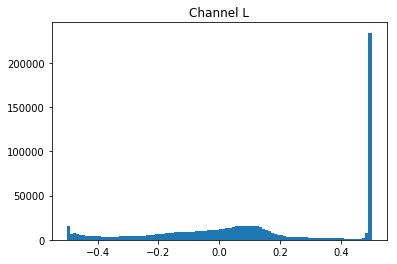

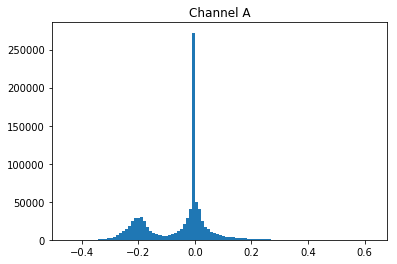

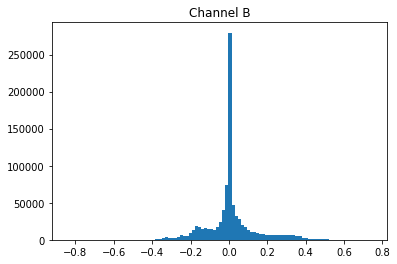

In [9]:
# EDA on channels L, A and B
import matplotlib.pyplot as plt
N = len(images_train_L)
im_L = images_train_L.flatten()
im_a = images_train_ab[:,:,:,0].flatten()
im_b = images_train_ab[:,:,:,1].flatten()
print("Number of training samples: ", N)
print("L: mean =",np.mean(im_L),", max =", np.max(im_L),", min =", np.min(im_L))
print("A: mean =",np.mean(im_a),", max =", np.max(im_a),", min =", np.min(im_a))
print("B: mean =",np.mean(im_b),", max =", np.max(im_b),", min =", np.min(im_b))

plt.hist(im_L, bins=100)
plt.title('Channel L')
plt.show()
plt.hist(im_a, bins=100)
plt.title('Channel A')
plt.show()
plt.hist(im_b, bins=100)
plt.title('Channel B')
plt.show()

# Define Computational Graph
Now time to define the network architecture. To this end, we will use Keras API, since it saves us a lot of time! Needless to say that we will be using TensorFlow as Backend.

In [10]:
import tensorflow as tf
sess = tf.Session()

import keras
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D

K.set_session(sess)

Using TensorFlow backend.


In [11]:
# this placeholder will contain our input images
img_in = tf.placeholder(tf.float32, shape=(None, 299, 299, 1))
img_emb = tf.placeholder(tf.float32, shape=(None, 1001))
img_out = tf.placeholder(tf.float32, shape=(None, 299, 299, 2))

We define the encoder and decoder networks. For the encoder, we only use convolutional and max pooling layers. Furthermore, we use ReLu as the activation function. 

In [12]:
def encoder(img_in):
    with tf.name_scope('encoder'):
        x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, )(
            img_in)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2, )(
            x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    return x

Before coloring, we merge the output from the *EncodeNet* with the feature vectors extracted using the Inception-Resnet-v2.

In [13]:
from keras.layers import RepeatVector, Permute, Reshape
from keras.layers import concatenate

def fusion(img_encoded, img_emb):
    #  Get size of inception feature vector
    # TODO try with img_emb.shape
    inception_len = img_emb.get_shape().as_list()[1]
    # Get sides of the image encoded by the conv layers
    img_side = img_encoded.get_shape().as_list()[1]

    # Repeat and reshape inception feature vector
    # (None, img_side * img_side, inception_len)
    img_emb = RepeatVector(img_side * img_side)(img_emb)

    # (None, img_side, img_side, inception_len)
    img_emb = Reshape((img_side, img_side, inception_len))(img_emb)

    # Concatenate inception with encode output
    # (None, img_side, img_side, inception_len + img_depth)
    concat = concatenate([img_emb, img_encoded], axis=3)
    # (None, img_side, img_side, fusion_out_depth)
    fusion_out_depth = 256
    fusion_out = Conv2D(fusion_out_depth, (1, 1), activation='relu', padding='same')(concat)
    return fusion_out

For the decoder, we use the same architecture but reversed. In addition, the last layer uses Tanh activation. Note that once processed, image pixels range [-1, 1] and thus makes it suitable to use Tanh in the last layer!

In [14]:
def decoder(encoded):
    with tf.name_scope('decoder'):
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(2, (3, 3), activation='tanh')(x)
        img_out = UpSampling2D((2, 2))(x)
    return img_out

We define the model using the decoder and encoder methods.

In [16]:
# Construct model
encoder_op = encoder(img_in)
print(encoder_op.shape)
fused = fusion(encoder_op, img_emb)
print(fused)
decoder_op = decoder(encoder_op)
print(decoder_op)

(?, 38, 38, 512)
Tensor("conv2d_13/Relu:0", shape=(?, 38, 38, 256), dtype=float32)
Tensor("decoder/up_sampling2d_3/ResizeNearestNeighbor:0", shape=(?, 300, 300, 2), dtype=float32)


We define the cost as the L2 pixel distance between the estimated and original picture. Furthermore, we use AdamOptimizer.

In [22]:
# Predictions
y_pred = decoder_op[:,:299,:299]
# Targets (Labels) are the input data.
y_true = img_out
# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.square(tf.subtract(y_pred, y_true)), name="mse")
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

# Training

Time for training😀😀 We initialize our variables and run the session. We also set the number of epochs and the batch size. Note that we use all the samples in the set (8) as the batch.

In [23]:
# Initialize all variables
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [24]:
training_epochs = 100
batch_size = 10
total_batches = N//batch_size

In [25]:
idx = np.arange(N)
# Run training loop
with sess.as_default():
    for epoch in range(training_epochs):
        np.random.shuffle(idx)
        images_train_L = images_train_L[idx]
        images_train_ab = images_train_ab[idx]
        images_train_emb = images_train_emb[idx]
        print("\nepoch:", epoch)
        for i in range(total_batches):
            batch_in = images_train_L[i*batch_size:(i+1)*batch_size]
            batch_emb = images_train_emb[i*batch_size:(i+1)*batch_size]
            batch_out = images_train_ab[i*batch_size:(i+1)*batch_size]
            _, c = sess.run([optimizer, cost], feed_dict={img_in: batch_in, img_out: batch_out, img_emb: batch_emb})
            print(str(i)+", Cost =  ", c)


epoch: 0
0, Cost =   0.0163895

epoch: 1
0, Cost =   0.0161854

epoch: 2
0, Cost =   0.0160065

epoch: 3
0, Cost =   0.0158129

epoch: 4
0, Cost =   0.0156933

epoch: 5
0, Cost =   0.0155936

epoch: 6
0, Cost =   0.0154305

epoch: 7
0, Cost =   0.0152258

epoch: 8
0, Cost =   0.0150575

epoch: 9
0, Cost =   0.0148926

epoch: 10
0, Cost =   0.0147073

epoch: 11
0, Cost =   0.0144998

epoch: 12
0, Cost =   0.0142687

epoch: 13
0, Cost =   0.0140171

epoch: 14
0, Cost =   0.0137174

epoch: 15
0, Cost =   0.0133773

epoch: 16
0, Cost =   0.0129974

epoch: 17
0, Cost =   0.0125858

epoch: 18
0, Cost =   0.0121127

epoch: 19
0, Cost =   0.0116124

epoch: 20
0, Cost =   0.0111134

epoch: 21
0, Cost =   0.0107793

epoch: 22
0, Cost =   0.0110659

epoch: 23
0, Cost =   0.0104944

epoch: 24
0, Cost =   0.010382

epoch: 25
0, Cost =   0.00984587

epoch: 26
0, Cost =   0.0100936

epoch: 27
0, Cost =   0.00941917

epoch: 28
0, Cost =   0.00968728

epoch: 29
0, Cost =   0.00931655

epoch: 30
0, Cos

Once we have our model, we simply evaluate it using some samples. In this first approach, we use training samples here but in the future we should be using validation samples.

In [29]:
# Run training loop
with sess.as_default():
    y_pred, y_true = sess.run([y_pred, y_true], feed_dict={img_in: images_train_L, img_out: images_train_ab, img_emb:images_train_emb })

Finally, we plot our results in order to see how good the reconstruction is.

In [123]:
# Get predictions!

def lab_to_rgb(img_l, img_ab):
    lab = np.empty([*img_l.shape[0:2], 3])
    img_l = img_l.reshape(299, 299)
    lab[:, :, 0] = (img_l + 1) * 50
    lab[:, :, 1:] = img_ab * 127
    return color.lab2rgb(lab)

img_pred = lab_to_rgb(images_train_L[0].reshape(299,299), images_train_ab[0])
imgs_pred = np.array([lab_to_rgb(images_train_L[k].reshape(299,299), y_pred[k]) for k in range(len(y_pred))])

In [145]:
# Plot predictions
import matplotlib
%matplotlib

imgs_gray = np.array([((i+1)*50).astype("uint8").reshape(299,299) for i in images_train_L])
print(idx)
idx2 = np.array([1, 6, 2, 3, 4, 5, 9, 6, 8, 7])
imgs_true = images_train_rgb[idx2]
for img_gray, img_pred, img_true in zip(imgs_gray, imgs_pred, imgs_true):
    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(img_gray, cmap="gray")
    axarr[0].set_title('Input Image')
    #axarr[1].imshow(img_pred)
    axarr[1].set_title('Reconstructed Image')
    axarr[2].imshow(img_true)
    axarr[2].set_title('Ground Truth')

    f.show()

Using matplotlib backend: MacOSX
[5 6 9 4 7 3 8 1 2 0]


In [137]:
idx

array([5, 6, 9, 4, 7, 3, 8, 1, 2, 0])

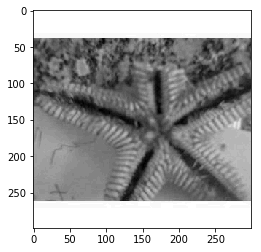

In [89]:
plt.imshow(img_gray.reshape(299,299), cmap="gray")

/Users/lucasrodesguirao/git/hashtag-nofilter/.env/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


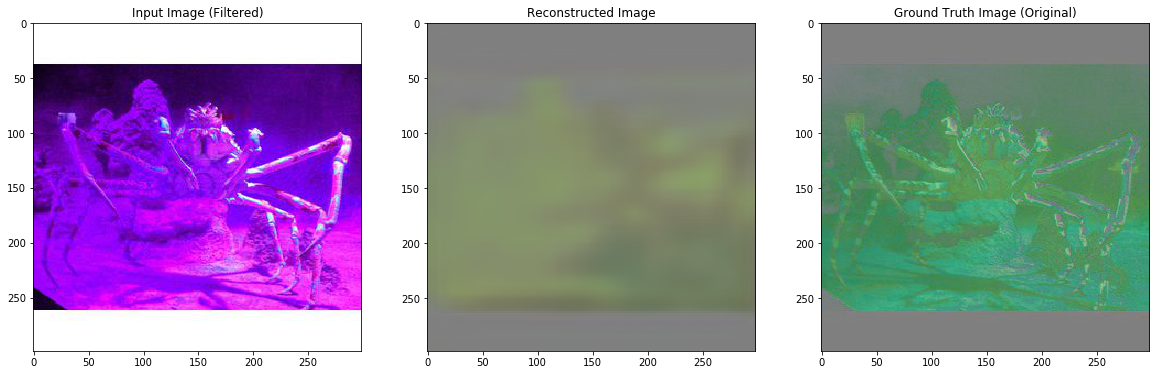

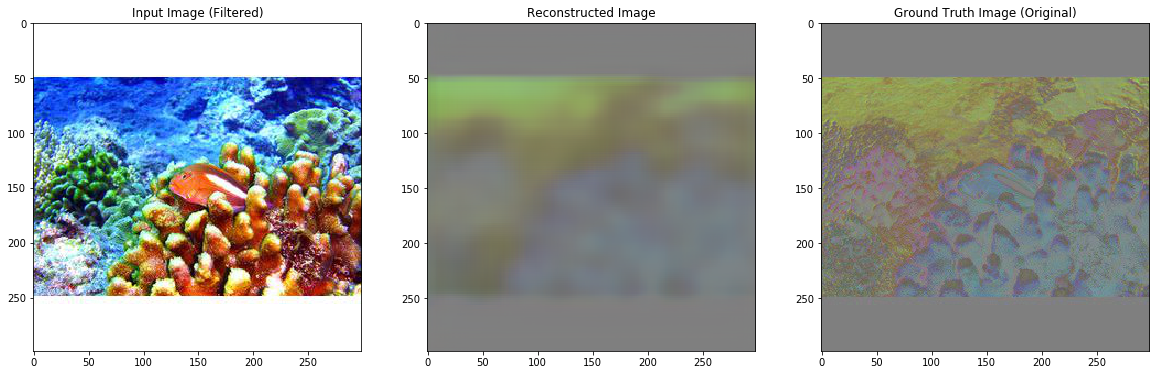

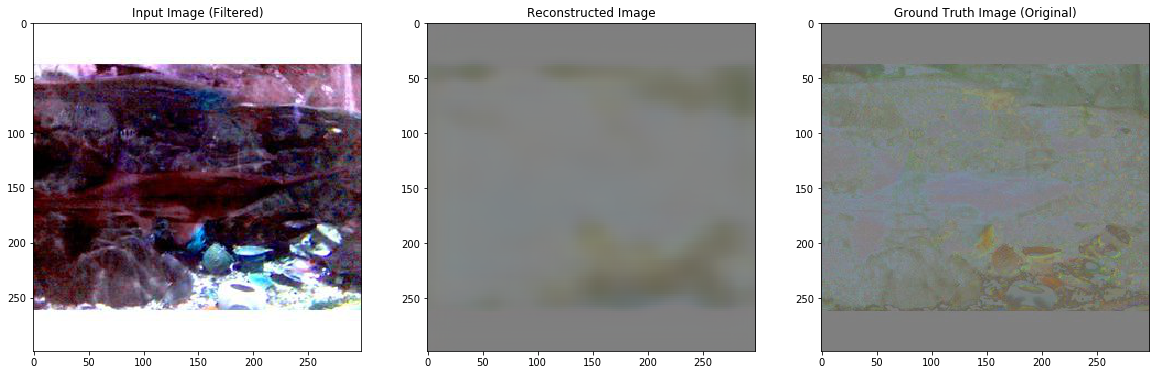

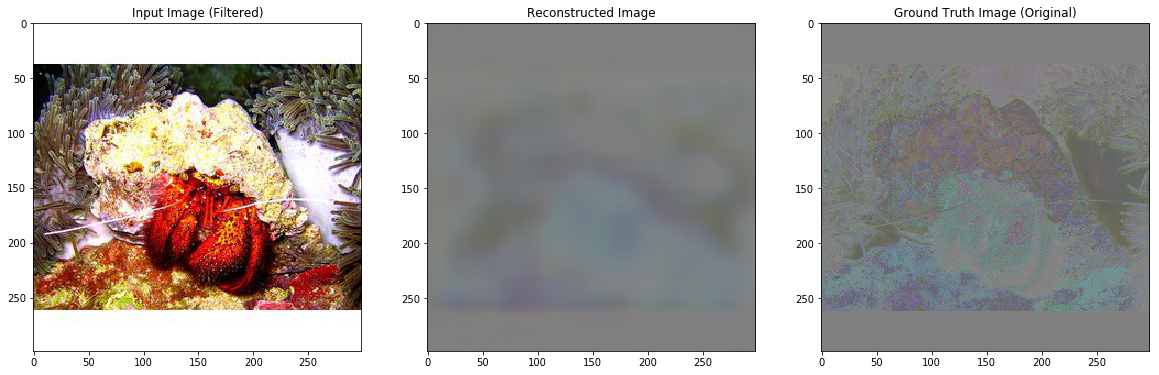

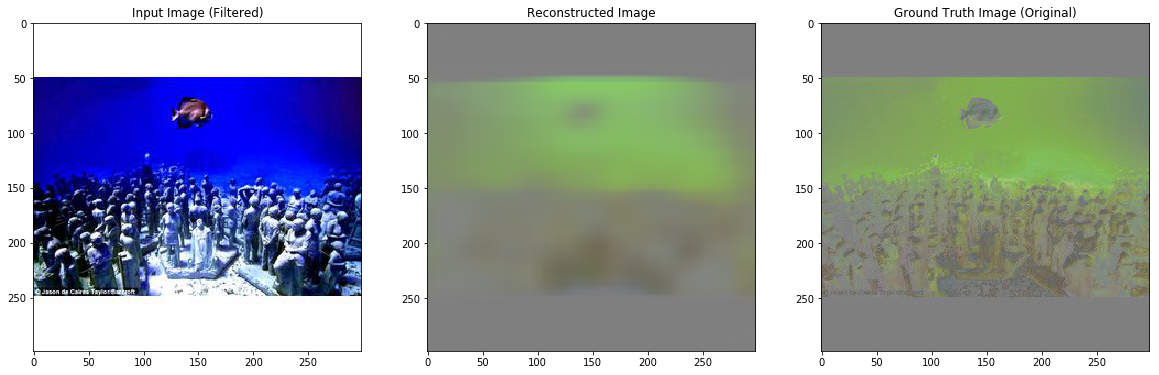

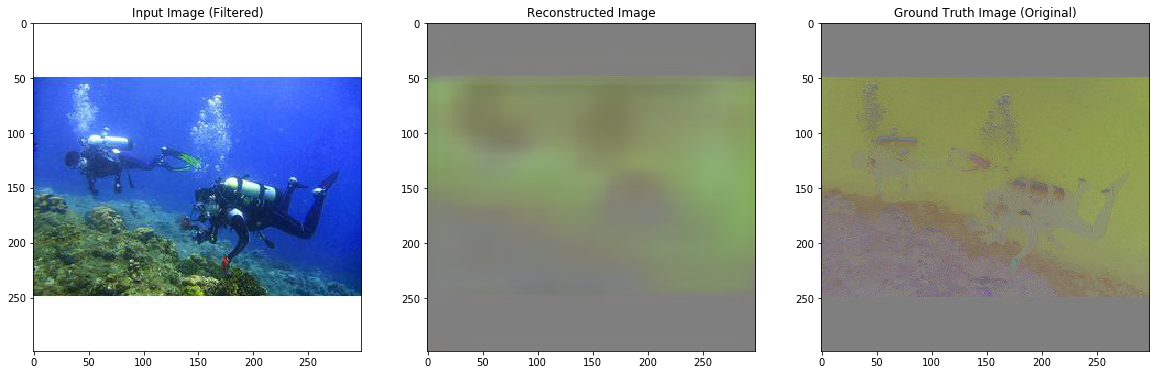

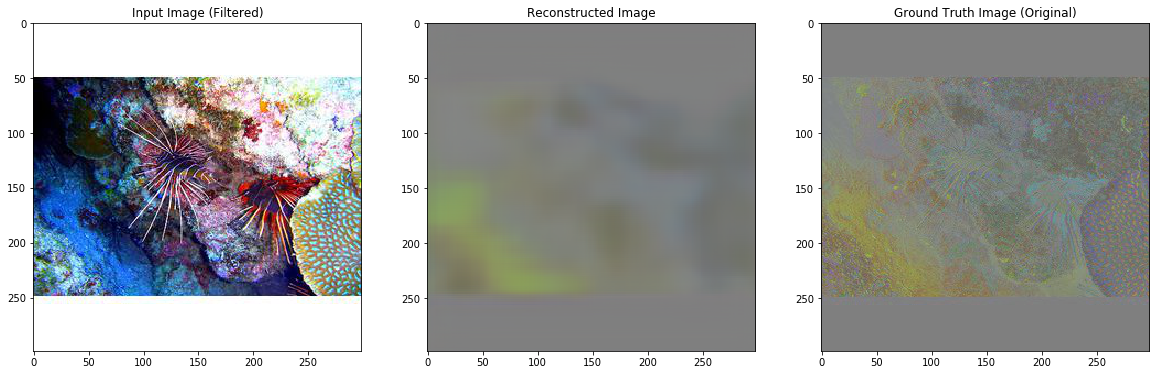

In [101]:
import matplotlib
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

for k in range(7):
    
    original = ((127.5*true[k])+127.5).astype("uint8")
    estimation = ((127.5*pred[k])+127.5).astype("uint8")
    filtered =  ((127.5*image_in[k])+127.5).astype("uint8")
    # Four axes, returned as a 2-d array
    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(filtered)
    axarr[0].set_title('Input Image (Filtered)')
    axarr[1].imshow(estimation)
    axarr[1].set_title('Reconstructed Image')
    axarr[2].imshow(original)
    axarr[2].set_title('Ground Truth Image (Original)')

    f.show()

TODO:

* Test this notebook using a TFRecord file
    * Add Merge Layer using Inception embeddings [ref](https://github.com/fchollet/keras/issues/4505)
* Need of a Validation set
* Padding: It feels like the network devotes some time trying to detect the padding. We might consider not caring at all what the network outputs in the padding regions.
* Adam Optimizer good? Learning Rate?
* Regularization term might be usefull in future.